In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath("./")))
from ase.build.ribbon import graphene_nanoribbon
from TB.hamiltonian import Hamiltonian
from TB.orbitals import Orbitals
from calc.utils import finite_difference
from TB.hamiltonian_initializer import set_tb_params, set_tb_params_bond_length
import torch
from calc.NEGF import NEGF

def create_graphene_nanoribbon(w=3.5, l=5):
    atoms = graphene_nanoribbon(w, l, type='armchair', saturated=True)

    period = np.array([list(atoms.get_cell()[2])])
    period[:, [1, 2]] = period[:, [2, 1]]
    coord = atoms.get_positions()

    coord[:, [1, 2]] = coord[:, [2, 1]]
    coords = []
    coords.append(str(len(coord)))
    coords.append('Nanoribbon')

    for j, item in enumerate(coord):
        coords.append('C' + str(j + 1) + ' ' + str(item[0]) + ' ' + str(item[1]) + ' ' + str(item[2]))

    coords = '\n'.join(coords)

    return period, coords

import numpy as np

def radial_dependence_func(bond_length, ne_bond_length, param):

        return (bond_length / ne_bond_length) ** param
        # return torch.exp(-param*(ne_bond_length/bond_length-1))

def sorting(coords, **kwargs):
    return np.argsort(coords[:, 1], kind='mergesort')

gamma0 = -2.97
gamma1 = -0.073
gamma2 = -0.33
s0 = 0.073
s1 = 0.018
s2 = 0.026



In [13]:
import time

time_count = {"na":[], "TT":{"FD":[], "AD":[]}, "Seebeck":{"FD":[], "AD":[]}, "DiffH":{"FD":[], "AD":[]}}
for l in range(1, 8):
    period, coords = create_graphene_nanoribbon(w=3.5, l=l)

    s_orb = Orbitals('C')
    s_orb.add_orbital("pz", energy=-0.28, orbital=1, magnetic=0, spin=0)

    set_tb_params(s_orb, PARAMS_C_C1={'pp_pi': gamma0},
                    PARAMS_C_C2={'pp_pi': gamma1},
                    PARAMS_C_C3={'pp_pi': gamma2},
                    OV_C_C1={'pp_pi': s0},
                    OV_C_C2={'pp_pi': s1},
                    OV_C_C3={'pp_pi': s2})

    h = Hamiltonian(xyz=coords, xyz_new=coords, nn_distance=[1.5, 2.5, 3.1], comp_overlap=True, sort_func=sorting).initialize()
    h.set_periodic_bc(period)
    n_a = h.get_site_coordinates().shape[0]
    time_count["na"].append(n_a)

    hL, hD, hR, sL, sD, sR = h.get_hamiltonians()
    hl_list, hd_list, hr_list, sl_list, sd_list, sr_list, subblocks = \
        h.get_hamiltonians_block_tridiagonal(optimized=True)
        

    def pack(**options):
        return options

    hmt_ovp = pack(hd=hd_list,hu=hr_list,hl=hl_list,sd=sd_list,su=sr_list,sl=sl_list,lhd=hD,lhu=hL.conj().T,lsd=sD,lsu=sL.conj().T,rhd=hD,rhu=hR,rsd=sD,rsu=sR)
    # plt.matshow(hD.detach().real, vmin=-5, vmax=0.5)
    # plt.colorbar()
    negf = NEGF(hmt_ovp)

    ee = torch.linspace(-3, 3, 1)

    # forward T(E)
        # AD

    # startAD = time.time()
    # result = negf.calGreen(
    #     ee = ee,
    #     ul = 0.,
    #     ur = 1.,
    #     calSeebeck=False,
    #     cutoff=True,
    #     calTT=True,
    #     ifSCF=False,
    #     d_trains=1,
    #     left_pos=period[0][0],
    #     right_pos=period[0][1],
    #     atom_coord=h.get_site_coordinates()[h._offsets],
    #     offset=h._offsets
    # )
    # endAD = time.time()
    # time_count["TT"]["AD"].append(endAD - startAD)

        # FD
    # startFD = time.perf_counter()
    # with torch.no_grad():
    #     result = negf.calGreen(
    #         ee = ee,
    #         ul = 0.,
    #         ur = 1.,
    #         calSeebeck=False,
    #         cutoff=True,
    #         calTT=True,
    #         ifSCF=False,
    #         d_trains=1,
    #         left_pos=period[0][0],
    #         right_pos=period[0][1],
    #         atom_coord=h.get_site_coordinates()[h._offsets],
    #         offset=h._offsets
    #     )
    # endFD = time.perf_counter()
    # time_count["TT"]["FD"].append(endFD - startFD)

    # Seebeck
        # AD
    startAD = time.time()
    result = negf.calGreen(
        ee = ee,
        ul = 0.,
        ur = 1.,
        calSeebeck=True,
        cutoff=True,
        ifSCF=False,
        d_trains=1,
        left_pos=period[0][0],
        right_pos=period[0][1],
        atom_coord=h.get_site_coordinates()[h._offsets],
        offset=h._offsets,
        sgfMethod="iterative"
    )
    endAD = time.time()
    time_count["Seebeck"]["AD"].append(endAD - startAD)

        # FD
    startFD = time.time()

    with torch.no_grad():
        f = lambda x: negf.calGreen(
            ee = x,
            ul = 0.,
            ur = 1.,
            calSeebeck=False,
            calTT=True,
            cutoff=True,
            ifSCF=False,
            d_trains=1,
            left_pos=period[0][0],
            right_pos=period[0][1],
            atom_coord=h.get_site_coordinates()[h._offsets],
            offset=h._offsets,
            sgfMethod="iterative"
        )["TT"].view(-1)
        for ie in ee:
            finite_difference(fn=f, x=ie, h=1e-5).detach()
    
    endFD = time.time()
    time_count["Seebeck"]["FD"].append(endFD - startFD)

    # 
    # Diff w.r.t. Hamiltonian

torch.save(obj=time_count, f="./timecount/time.pth")



C
Converged very well at 54.
Converged very well at 54.
Converged very well at 66.
Converged very well at 54.
Converged very well at 72.
Converged very well at 51.
C
Converged very well at 67.
Converged very well at 63.
Converged very well at 103.
Converged very well at 54.
Converged very well at 105.
Converged very well at 78.
C
Converged very well at 57.
Converged very well at 45.
Converged very well at 57.
Converged very well at 63.
Converged very well at 54.
Converged very well at 60.
C
Converged very well at 60.
Converged very well at 63.
Converged very well at 57.
Converged very well at 66.
Converged very well at 108.
Converged very well at 63.
C
Converged very well at 51.
Converged very well at 72.
Converged very well at 68.
Converged very well at 81.
Converged very well at 48.
Converged very well at 87.
C
Converged very well at 99.
Converged very well at 69.
Converged very well at 69.
Converged very well at 48.
Converged very well at 81.
Converged very well at 57.
C
Converged v

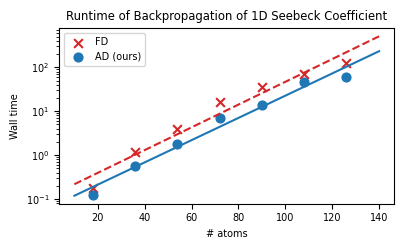

[18, 36, 54, 72, 90, 108, 126] [0.17427587509155273, 1.1768248081207275, 3.9514875411987305, 16.177376985549927, 34.709282875061035, 68.89674520492554, 127.52366089820862] [0.12501311302185059, 0.5499532222747803, 1.787801742553711, 6.861363887786865, 14.039674758911133, 45.28853249549866, 60.114211320877075]


In [47]:
def linear(X, Y, start, end, num):
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()
    X = torch.stack([X,torch.ones_like(X)], dim=1)
    W = (X.T @ X).inverse() @ X.T @ Y.unsqueeze(1)

    x = torch.linspace(start=start, end=end, steps=num)
    y = torch.stack([x, torch.ones_like(x)], dim=1) @ W
    return x, y

a = torch.load("./timecount/time.pth")

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(4,2.5))
plt.scatter(a["na"],a["Seebeck"]["FD"],  s=40, marker="x", c='tab:red', label="FD")
x, y = linear(a["na"], np.log(a["Seebeck"]["FD"]), start=10, end=140, num=100)
plt.plot(x,np.exp(y),'--', c="tab:red")
plt.scatter(a["na"],a["Seebeck"]["AD"],  s=40, marker="o", c='tab:blue', label="AD (ours)")
x, y = linear(a["na"], np.log(a["Seebeck"]["AD"]), start=10, end=140, num=100)
plt.plot(x,np.exp(y), c="tab:blue")
plt.xlabel("# atoms")
plt.ylabel("Wall time")
plt.title("Runtime of Backpropagation of 1D Seebeck Coefficient")
plt.legend(loc="best")
plt.tight_layout()
plt.yscale("log")
plt.savefig("../img/CostBW1D.pdf", dpi=100)
plt.show()

print(a["na"],a["Seebeck"]["FD"],a["Seebeck"]["AD"])
# fig = plt.figure(figsize=(4,2.5))
# plt.scatter(a["na"],a["TT"]["FD"],  s=40, marker="x", c='tab:red', label="w/ Op Tracking")
# x, y = linear(a["na"], a["TT"]["FD"], start=10, end=170, num=100)
# plt.plot(x,y, '--',c="tab:red")
# plt.scatter(a["na"],a["TT"]["AD"],  s=40, marker="x", c='tab:blue', label="w/o Op Tracking")
# x, y = linear(a["na"], a["TT"]["AD"], start=10, end=170, num=100)
# plt.plot(x,y, c="tab:blue")
# plt.xlabel("# atoms")
# plt.ylabel("CPU time")
# plt.title("Runtime of Forward Simulation")
# plt.legend(loc="upper left")
# plt.tight_layout()
# plt.savefig("../img/CostFW.pdf", dpi=100)
# plt.show()

In [38]:
import time

time_count = {"na":[], "DiffH":{"FD":[], "AD":[]}}
for l in range(1,7):
    period, coords = create_graphene_nanoribbon(w=3.5, l=l)

    s_orb = Orbitals('C')
    s_orb.add_orbital("pz", energy=-0.28, orbital=1, magnetic=0, spin=0)

    set_tb_params(s_orb, PARAMS_C_C1={'pp_pi': gamma0},
                    PARAMS_C_C2={'pp_pi': gamma1},
                    PARAMS_C_C3={'pp_pi': gamma2},
                    OV_C_C1={'pp_pi': s0},
                    OV_C_C2={'pp_pi': s1},
                    OV_C_C3={'pp_pi': s2})

    h = Hamiltonian(xyz=coords, xyz_new=coords, nn_distance=[1.5, 2.5, 3.1], comp_overlap=True, sort_func=sorting).initialize()
    h.set_periodic_bc(period)
    n_a = h.get_site_coordinates().shape[0]
    time_count["na"].append(n_a)

    hL, hD, hR, sL, sD, sR = h.get_hamiltonians()
    hl_list, hd_list, hr_list, sl_list, sd_list, sr_list, subblocks = \
        h.get_hamiltonians_block_tridiagonal(optimized=True)

    def pack(**options):
        return options

    hmt_ovp = pack(hd=hd_list,hu=hr_list,hl=hl_list,sd=sd_list,su=sr_list,sl=sl_list,lhd=hD,lhu=hL.conj().T,lsd=sD,lsu=sL.conj().T,rhd=hD,rhu=hR,rsd=sD,rsu=sR)
    # plt.matshow(hD.detach().real, vmin=-5, vmax=0.5)
    # plt.colorbar()
    negf = NEGF(hmt_ovp)
    
    for i, x in enumerate(hmt_ovp["hd"]):
        hmt_ovp["hd"][i] = x.detach()
        hmt_ovp["hd"][i].requires_grad_()
    
    ee = torch.scalar_tensor(0.)

    # diff H 
        # AD
    negf = NEGF(hmt_ovp)
    startAD = time.perf_counter()
    result = negf.calGreen(
        ee = ee,
        ul = 0.,
        ur = 1.,
        calSeebeck=False,
        cutoff=True,
        ifSCF=False,
        calTT=True,
        d_trains=1,
        left_pos=period[0][0],
        right_pos=period[0][1],
        atom_coord=h.get_site_coordinates()[h._offsets],
        offset=h._offsets,
        sgfMethod="other"
    )["TT"]
    grad = torch.autograd.grad(result, hmt_ovp["hd"])
    endAD = time.perf_counter()
    time_count["DiffH"]["AD"].append(endAD - startAD)

        # FD
    startFD = time.perf_counter()

    with torch.no_grad():
        def func(hd, i):
            hmt_ovp["hd"][i] = hd
            
            return NEGF(hmt_ovp).calGreen(
                ee = ee,
                ul = 0.,
                ur = 1.,
                calSeebeck=False,
                calTT=True,
                cutoff=True,
                ifSCF=False,
                d_trains=1,
                left_pos=period[0][0],
                right_pos=period[0][1],
                atom_coord=h.get_site_coordinates()[h._offsets],
                offset=h._offsets,
                sgfMethod="other"
            )["TT"].view(-1)
        
        for i in range(len(hmt_ovp["hd"])):
            f = lambda x: func(x, i)
            finite_difference(fn=f, x=hmt_ovp["hd"][i], h=1e-5).detach()
    
    endFD = time.perf_counter()
    time_count["DiffH"]["FD"].append(endFD - startFD)
    print(time_count["DiffH"]["FD"][-1], time_count["DiffH"]["AD"][-1])

    # 
    # Diff w.r.t. Hamiltonian

torch.save(obj=time_count, f="./timecount/Htime_.pth")

C
5.264098776970059 0.017699053045362234
C
20.144672540947795 0.02442267001606524
C
34.71012789802626 0.03504609898664057
C
55.34622501721606 0.039495452074334025
C
106.48251263704151 0.05444765300489962
C
156.7793264379725 0.08579287910833955


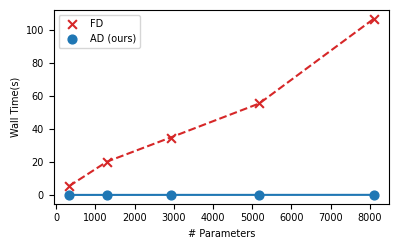

In [48]:
import torch
import matplotlib

a = torch.load("./timecount/Htime_.pth")
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['pdf.fonttype'] = 42

fig = plt.figure(figsize=(4,2.5))
plt.scatter([i**2 for i in a["na"][:-1]],a["DiffH"]["FD"][:-1], s=40, marker="x", c='tab:red', label="FD")
plt.scatter([i **2 for i in a["na"][:-1]],a["DiffH"]["AD"][:-1], s=40, marker="o", c='tab:blue', label="AD (ours)")
plt.plot([i**2 for i in a["na"][:-1]], a["DiffH"]["FD"][:-1], '--', c='tab:red')
plt.plot([i**2 for i in a["na"][:-1]], a["DiffH"]["AD"][:-1], c='tab:blue')
plt.legend()
plt.xlabel(r"# Parameters")
plt.ylabel("Wall Time(s)")
# plt.title("Runtime of Backpropagation for High-Dimentional Hamiltonians")
plt.tight_layout()
# plt.yscale("log")
plt.savefig("../img/CostBWND.pdf", dpi=100)
plt.show()

In [50]:
print([i**2 for i in a["na"][:-1]])
print(a["DiffH"]["FD"][:-1])
print(a["DiffH"]["AD"][:-1])

[324, 1296, 2916, 5184, 8100]
[5.264098776970059, 20.144672540947795, 34.71012789802626, 55.34622501721606, 106.48251263704151]
[0.017699053045362234, 0.02442267001606524, 0.03504609898664057, 0.039495452074334025, 0.05444765300489962]
